- reference: https://github.com/dh1105/Sentence-Entailment/blob/main/Sentence_Entailment_BERT.ipynb

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
import pickle
import json
import os
from os import listdir
from os.path import isfile, join
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# change the model, 1 for deberta, 0 for bert
choice = 1
# change path data where the data files
path_data = '/content/drive/My Drive/multi-evidence-nli-nlp-243-master/Data/'

In [ ]:
# set the deviceto gpu if it exist
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# get train.json and force it into single data type
f = open(path_data + 'train.json') 
data = json.load(f)
f.close()
df=pd.DataFrame.from_dict(data, orient='index')
df = df[df.Type == "Single"]
df.head()

,Type,Section_id,Primary_id,Secondary_id,Statement,Label,Primary_evidence_index,Secondary_evidence_index
86b7cb3d-6186-4a04-9aa6-b174ab764eed,Single,Eligibility,NCT00662129,NaN,"Patients with Platelet count over 100,000/mm¬¨...",Contradiction,"[18, 22, 23, 24]",NaN
20c35c89-8d23-4be3-b603-ac0ee0f3b4de,Single,Eligibility,NCT01097642,NaN,Adult Patients with histologic confirmation of...,Contradiction,"[0, 1, 3, 4, 5]",NaN
96b77cdd-aa9f-4770-8447-8a04d9ca5da7,Single,Eligibility,NCT00633750,NaN,Patients with Clinical stage II (T2 N1) invasi...,Contradiction,"[0, 1, 4, 10]",NaN
8765009d-ffc4-4395-ab7a-11ecdfd43a40,Single,Eligibility,NCT00201773,NaN,Adele is an 85 year old woman with Stage II hi...,Entailment,"[0, 1, 2, 3, 4, 6]",NaN
2bc1e094-41a1-46d9-9b0c-b5a47f23323d,Single,Eligibility,NCT00895414,NaN,Certain drinks are banned for patients underta...,Entailment,"[0, 8]",NaN


In [ ]:
# traverse the CTR file to get all the CTRs
dir_path = path_data + 'CT json'
all_json_files = [join(dir_path, f) for f in listdir(dir_path) if isfile(join(dir_path, f)) and f.endswith(".json")]
ctr_list = []
for file_path in all_json_files:
    with open(file_path) as input_file:
        json_array = json.load(input_file)
        ctr_list.append(json_array)
ctr_df_old = pd.json_normalize(ctr_list)
ctr_df = pd.DataFrame()
# combine each secions from list of phrases into one set of string
ctr_df['Clinical Trial ID'] = ctr_df_old['Clinical Trial ID']
ctr_df['Intervention'] = ctr_df_old['Intervention'].apply(lambda x: "".join(x)) 
ctr_df['Eligibility'] = ctr_df_old['Eligibility'].apply(lambda x: "".join(x))
ctr_df['Results'] = ctr_df_old['Results'].apply(lambda x: "".join(x)) 
ctr_df['Adverse Events'] = ctr_df_old['Adverse Events'].apply(lambda x: "".join(x))
ctr_df.head()

,Clinical Trial ID,Intervention,Eligibility,Results,Adverse Events
0,NCT00001832,INTERVENTION 1: Abl Cells IV + Cyclophospham...,INCLUSION CRITERIA Patients must have evaluab...,Outcome Measurement: Clinical Response Comp...,Adverse Events 1: Total: 0/3 (0.00%) Lymphoc...
1,NCT00003199,INTERVENTION 1: TX/Maintenance Therapy for S...,Inclusion Criteria: Patients with inflammator...,Outcome Measurement: Event-free Survival Ev...,Adverse Events 1: Total: 2/50 (4.00%) Prolon...
2,NCT00003404,INTERVENTION 1: Adjuvant Radiotherapy Adjuv...,DISEASE CHARACTERISTICS: Histologically prove...,Outcome Measurement: Local Recurrence Rate ...,Adverse Events 1: Total: 0/46 (0.00%)
3,NCT00003782,INTERVENTION 1: Arm 1: Doxorubicin + Cycloph...,DISEASE CHARACTERISTICS: Histologically confi...,Outcome Measurement: Overall Survival [Not ...,Adverse Events 1: Total: 66/1748 (3.78%) Feb...
4,NCT00003830,INTERVENTION 1: Arm I:Sentinel Node Resectio...,DISEASE CHARACTERISTICS: Resectable invasive ...,Outcome Measurement: Morbidity - Number of P...,Adverse Events 1: Total: 9/2788 (0.32%) Anap...


In [ ]:
row_list =[]
# Iterate over each row
for index, rows in ctr_df.iterrows():
    my_list =[rows.Intervention, rows.Eligibility, rows.Results, rows['Adverse Events']]
    # append the list to the final list
    row_list.append(my_list)
ctr_df['premise'] = row_list
ctr_df.head()

,Clinical Trial ID,Intervention,Eligibility,Results,Adverse Events,premise
0,NCT00001832,INTERVENTION 1: Abl Cells IV + Cyclophospham...,INCLUSION CRITERIA Patients must have evaluab...,Outcome Measurement: Clinical Response Comp...,Adverse Events 1: Total: 0/3 (0.00%) Lymphoc...,[INTERVENTION 1: Abl Cells IV + Cyclophospha...
1,NCT00003199,INTERVENTION 1: TX/Maintenance Therapy for S...,Inclusion Criteria: Patients with inflammator...,Outcome Measurement: Event-free Survival Ev...,Adverse Events 1: Total: 2/50 (4.00%) Prolon...,[INTERVENTION 1: TX/Maintenance Therapy for ...
2,NCT00003404,INTERVENTION 1: Adjuvant Radiotherapy Adjuv...,DISEASE CHARACTERISTICS: Histologically prove...,Outcome Measurement: Local Recurrence Rate ...,Adverse Events 1: Total: 0/46 (0.00%),[INTERVENTION 1: Adjuvant Radiotherapy Adju...
3,NCT00003782,INTERVENTION 1: Arm 1: Doxorubicin + Cycloph...,DISEASE CHARACTERISTICS: Histologically confi...,Outcome Measurement: Overall Survival [Not ...,Adverse Events 1: Total: 66/1748 (3.78%) Feb...,[INTERVENTION 1: Arm 1: Doxorubicin + Cyclop...
4,NCT00003830,INTERVENTION 1: Arm I:Sentinel Node Resectio...,DISEASE CHARACTERISTICS: Resectable invasive ...,Outcome Measurement: Morbidity - Number of P...,Adverse Events 1: Total: 9/2788 (0.32%) Anap...,[INTERVENTION 1: Arm I:Sentinel Node Resecti...


In [ ]:
# whether or not the current pair should keep the label
def change_label(df, statement, cid):
    if df[df['Statement']==statement]['Section_id'][0] == cid:
        return False
    else:
        return True
new_df= df[['Primary_id','Label','Statement']].copy()
p_list = []
section_list = []
# get premise and different sections list
for i, j in new_df.iterrows():
    temp = ctr_df.loc[ctr_df['Clinical Trial ID'] == j['Primary_id']].drop('Clinical Trial ID', inplace=False, axis=1)
    p_list.append(temp['premise'].item())
    section_list.append(['Intervention', 'Eligibility', 'Results', 'Adverse Events'])
    
new_df['Premise'] = p_list
new_df['Section_id'] = section_list
new_df = new_df.explode(['Premise', 'Section_id'], ignore_index=True)
label_list = []

# change the label to neutral if it is not in section id
for i, j in new_df.iterrows():
    if change_label(df, j['Statement'], j['Section_id']):
        label_list.append('Neutral')
    else:
        label_list.append(j['Label'])
new_df['Label'] = label_list  
new_df.head()


,Primary_id,Label,Statement,Premise,Section_id
0,NCT00662129,Neutral,"Patients with Platelet count over 100,000/mm¬¨...",INTERVENTION 1: Paclitaxel + Gemcitabine + B...,Intervention
1,NCT00662129,Contradiction,"Patients with Platelet count over 100,000/mm¬¨...",DISEASE CHARACTERISTICS: Histologically or cy...,Eligibility
2,NCT00662129,Neutral,"Patients with Platelet count over 100,000/mm¬¨...",Outcome Measurement: 6-month Progression-fre...,Results
3,NCT00662129,Neutral,"Patients with Platelet count over 100,000/mm¬¨...",Adverse Events 1: Total: 20/49 (40.82%) Febr...,Adverse Events
4,NCT01097642,Neutral,Adult Patients with histologic confirmation of...,INTERVENTION 1: Ixabepilone Brand name is I...,Intervention


In [ ]:
#get test data by splitting them into 7:1.5:1.5 sections
def get_train_val_test_df_data_split(df):
    test_ind = int(len(df)*0.85)
    val_ind = int(len(df)*0.7)            
    while test_ind > val_ind:

        if df[test_ind:test_ind+1]['Statement'].item() == df[test_ind-1:test_ind]['Statement'].item():
            test_ind-=1
        else:
            break
    return df[:val_ind], df[val_ind:test_ind], df[test_ind:]

In [ ]:
train_df, val_df, test_df = get_train_val_test_data_split(new_df)

In [ ]:
print(train_df['Label'].value_counts())
print(val_df['Label'].value_counts())
print(test_df['Label'].value_counts())

Neutral          2174
Entailment        374
Contradiction     350
Name: Label, dtype: int64
Neutral          463
Contradiction     81
Entailment        74
Name: Label, dtype: int64
Neutral          468
Entailment        85
Contradiction     71
Name: Label, dtype: int64


In [ ]:
# under-sampling for training and validation data

random_state = 42
train_min = min(train_df['Label'].value_counts())
s0 = train_df.Label[train_df.Label.eq("Neutral")].sample(train_min, random_state=random_state).index
s1 = train_df.Label[train_df.Label.eq("Contradiction")].sample(train_min, random_state=random_state).index 
s2 = train_df.Label[train_df.Label.eq("Entailment")].sample(train_min, random_state=random_state).index 
train_df = train_df.loc[s0.union(s1).union(s2)]

val_min = min(val_df['Label'].value_counts())
s0 = val_df.Label[val_df.Label.eq("Neutral")].sample(val_min, random_state=random_state).index
s1 = val_df.Label[val_df.Label.eq("Contradiction")].sample(val_min, random_state=random_state).index 
s2 = val_df.Label[val_df.Label.eq("Entailment")].sample(val_min, random_state=random_state).index 
val_df = val_df.loc[s0.union(s1).union(s2)]

In [ ]:
print(train_df['Label'].value_counts())
print(val_df['Label'].value_counts())
print(test_df['Label'].value_counts())

Contradiction    350
Entailment       350
Neutral          350
Name: Label, dtype: int64
Entailment       74
Neutral          74
Contradiction    74
Name: Label, dtype: int64
Neutral          468
Entailment        85
Contradiction     71
Name: Label, dtype: int64


#### Prepare dataset

In [ ]:
class MNLIDataBert(Dataset):

    def __init__(self, train_df, val_df, test_df):
        self.label_dict = {'Entailment': 0, 'Contradiction': 1, 'Neutral': 2}

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # if choice is 0, choose bert, otherwise choose deberta
        if choice == 0:
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
        else:
            self.tokenizer = AutoTokenizer.from_pretrained('cross-encoder/nli-deberta-base')
        self.train_data = None
        self.val_data = None
        self.test_data = None
        self.init_data()
    # load data splits
    def init_data(self):
        self.train_data = self.load_data(self.train_df)
        self.val_data = self.load_data(self.val_df)
        self.test_data = self.load_data(self.test_df)

    def load_data(self, df):
        MAX_LEN = 512
        token_ids = []
        mask_ids = []
        seg_ids = []
        y = []
        
        # tokenize the premise and the hypothesis
        premise_list = df['Premise'].to_list()
        hypothesis_list = df['Statement'].to_list()
        label_list = df['Label'].to_list()

        for (premise, hypothesis, label) in zip(premise_list, hypothesis_list, label_list):
            # tokenize the premise and the hypothesis
            hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
            premise_id = self.tokenizer.encode(premise, add_special_tokens = False, truncation=True, max_length=MAX_LEN-len(hypothesis_id))
            # apply cls and sep token to the premise and hypothesis
            pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]
            premise_len = len(premise_id)
            hypothesis_len = len(hypothesis_id)
            # get the mask id
            segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
            attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values
            
            token_ids.append(torch.tensor(pair_token_ids))
            seg_ids.append(segment_ids)
            mask_ids.append(attention_mask_ids)
            y.append(self.label_dict[label])
            
        # pad the sequence for the dataset
        token_ids = pad_sequence(token_ids, batch_first=True)
        mask_ids = pad_sequence(mask_ids, batch_first=True)
        seg_ids = pad_sequence(seg_ids, batch_first=True)
        y = torch.tensor(y)
        dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
        return dataset
    
    # get dataloaders for data splits
    def get_data_loaders(self, batch_size=32, shuffle=True):
        train_loader = DataLoader(
          self.train_data,
          shuffle=shuffle,
          batch_size=batch_size
        )

        val_loader = DataLoader(
          self.val_data,
          shuffle=shuffle,
          batch_size=batch_size
        )

        test_loader = DataLoader(
          self.test_data,
          shuffle=False,
          batch_size=batch_size
        )

        return train_loader, val_loader, test_loader

In [ ]:
mnli_dataset = MNLIDataBert(train_df, val_df, test_df)

1050
222
624


In [ ]:
train_loader, val_loader, test_loader = mnli_dataset.get_data_loaders(batch_size=2)

In [ ]:
# if choice is 0, choose bert, otherwise choose deberta
if choice == 0:
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
else:
    model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/nli-deberta-base')
model.to(device)

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermed

In [ ]:
param_optimizer = list(model.named_parameters())
# set weight decay value against bias, gamma, and beta
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.05},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-6)


The model has 139,194,627 trainable parameters


In [ ]:
# calculating the accuracy for multi-label
def multi_acc(y_pred, y_test):
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

In [ ]:
from tqdm import tqdm

In [ ]:
import time
# set manual seed to 0 so that the result is reproducible
torch.manual_seed(0)
# set num of epoch
EPOCHS = 3

def train(model, train_loader, val_loader, optimizer):  
    total_step = len(train_loader)
    
    for epoch in range(EPOCHS):
        start = time.time()
        model.train()
        total_train_loss = 0
        total_train_acc  = 0
        # get the training batch
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch}")
                optimizer.zero_grad()
                pair_token_ids = pair_token_ids.to(device)
                mask_ids = mask_ids.to(device)
                seg_ids = seg_ids.to(device)
                labels = y.to(device)
                
                # get prediction logits and loss
                loss, prediction = model(pair_token_ids, 
                                  token_type_ids=seg_ids, 
                                  attention_mask=mask_ids, 
                                  labels=labels).values()
                # get final predictions
                pred = torch.log_softmax(prediction, dim=1).argmax(dim=1)
                # get multi label accuracy
                acc = multi_acc(prediction, labels)
                
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                total_train_acc  += acc.item()
        # calculate the traning accuracy and loss
        train_acc  = total_train_acc/len(train_loader)
        train_loss = total_train_loss/len(train_loader)
        
        model.eval()
        total_val_acc  = 0
        total_val_loss = 0
        
        # calculate the traning accuracy and loss
        with torch.no_grad():
            for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
                optimizer.zero_grad()
                pair_token_ids = pair_token_ids.to(device)
                mask_ids = mask_ids.to(device)
                seg_ids = seg_ids.to(device)
                labels = y.to(device)

                # get prediction logits and loss
                loss, prediction = model(pair_token_ids, 
                                    token_type_ids=seg_ids, 
                                    attention_mask=mask_ids, 
                                    labels=labels).values()

                # get final accuracy
                acc = multi_acc(prediction, labels)

                total_val_loss += loss.item()
                total_val_acc  += acc.item()
                
        # calculate the traning accuracy and loss
        val_acc  = total_val_acc/len(val_loader)
        val_loss = total_val_loss/len(val_loader)
        end = time.time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)

        print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


In [ ]:
t_l, t_a, v_l, v_a = train(model, train_loader, val_loader, optimizer)

Epoch 0:   0%|                                                                              | 0/525 [00:00<?, ?batch/s]E:\Anaconda\lib\site-packages\transformers\models\deberta\modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
E:\Anaconda\lib\site-packages\transformers\models\deberta\modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
Epoch 0: 100%|████████████████████████████████████████████████████████████████████| 525/525 [01:24<00:00,  6.24batch/s]


Epoch 1: train_loss: 1.0578 train_acc: 0.4724 | val_loss: 0.9473 val_acc: 0.4685
00:01:28.89


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 525/525 [01:22<00:00,  6.36batch/s]


Epoch 2: train_loss: 0.8144 train_acc: 0.5686 | val_loss: 0.8243 val_acc: 0.5405
00:01:27.24


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 525/525 [01:23<00:00,  6.27batch/s]


Epoch 3: train_loss: 0.6567 train_acc: 0.6229 | val_loss: 0.7200 val_acc: 0.5766
00:01:28.52


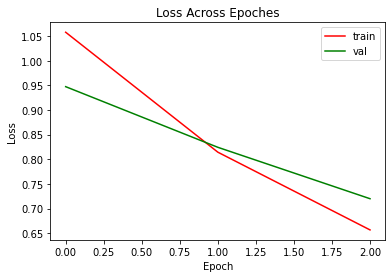

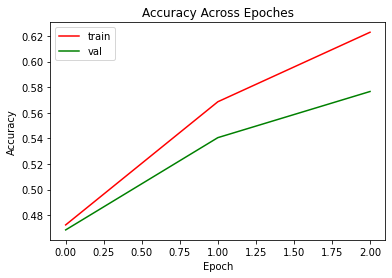

In [ ]:
def get_predictions(model, test_loader, optimizer):
    all_predictions = []
    all_labels = []
    with torch.no_grad():
          for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(test_loader):
            optimizer.zero_grad()
            pair_token_ids = pair_token_ids.to(device)
            mask_ids = mask_ids.to(device)
            seg_ids = seg_ids.to(device)
            labels = y.to(device)
            all_labels.append(labels)
            # get prediction logits and loss
            loss, prediction = model(pair_token_ids, 
                                token_type_ids=seg_ids, 
                                attention_mask=mask_ids, 
                                labels=labels).values()
            # get final predictions
            pred = torch.log_softmax(prediction, dim=1).argmax(dim=1).float()
            # save the predictions
            all_predictions.append(pred)
            
    return all_predictions, all_labels

In [ ]:
all_test_predictions, all_test_labels = get_predictions(model, test_loader, optimizer)

E:\Anaconda\lib\site-packages\transformers\models\deberta\modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
E:\Anaconda\lib\site-packages\transformers\models\deberta\modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


In [ ]:
# flatten the returned label
test_labels = [x.tolist() for x in all_test_labels]
test_labels = [j for sub in test_labels for j in sub]

312

In [ ]:
# flatten the predictions
test_predictions = [x.tolist() for x in all_test_predictions]
test_predictions = [j for sub in test_predictions for j in sub]

624 624


In [ ]:
# regroup the final test
def get_final_ans(df, pred):
    idx = 0
    grouped_ans = []
    group = []
    while idx < len(df)-1:
        if df[idx:idx+1]['Statement'].item() == df[idx+1:idx+2]['Statement'].item():
            group.append(pred[idx])
        else:
            group.append(pred[idx])
            grouped_ans.append(group)
            group = []
        idx+=1
    return grouped_ans

final_grouping = get_final_ans(test_df, test_predictions)

In [ ]:
import collections
import random
random.seed(0)
# get final prediction by grouping
def get_final_pred(grouping):
    ans = []
    ignore = {2.0}
    for i, g in enumerate(grouping):
        frequency = collections.Counter(x for x in g if x not in ignore).most_common(1)
        # if the model predict all neutral, we have to randomly 
        if len(frequency) == 0:
            frequency = random.randint(0,1)
        else:
            frequency = frequency[0][0]
        ans.append(frequency)
    return ans
prediction = get_final_pred(final_grouping)

In [ ]:
def get_hypothesis(df):
    idx = 0
    grouped_ans = []
    group = []
    while idx < len(df)-1:
        # if they are the same hypothesis, get them back into one
        if df[idx:idx+1]['Statement'].item() == df[idx+1:idx+2]['Statement'].item():
            idx+=1
            continue
        else:
            group.append(df[idx:idx+1]['Statement'].item())
        idx+=1
    return group

In [ ]:
h_lst = get_hypothesis(test_df)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

label_dict = {'entailment': 0, 'contradiction': 1}

true = []
for h in h_lst:
    true.append(label_dict[df[df['Statement'] == h]['Label'].tolist()[0].lower()])


print(classification_report(true, prediction))

              precision    recall  f1-score   support

           0       0.54      0.63      0.58        84
           1       0.46      0.37      0.41        71

    accuracy                           0.51       155
   macro avg       0.50      0.50      0.49       155
weighted avg       0.50      0.51      0.50       155

[[53 31]
 [45 26]]
